In [1]:
import torch
import torch.nn.functional as F
import random
import math
import matplotlib.pyplot as plt

In [2]:
file = open("/home/mviswanathsai/Downloads/names.txt", "r")
words = file.read().splitlines()

In [3]:
alphabets = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(alphabets)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
def build_dataset(words): 
    X, Y = [], []
    batchsize = 4
    
    for w in words:
        context = [0] * batchsize
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y 

random.seed(42)
random.shuffle(words)

total_size = len(words)
train_size = int(0.8 * total_size)  # 80%
dev_size = int(0.1 * total_size)    # 10%
test_size = total_size - train_size - dev_size

# 4. Perform the slicing
train_data = words[:train_size]
dev_data = words[train_size : train_size + dev_size]
test_data = words[train_size + dev_size :]

Xtr, Ytr = build_dataset(train_data)
Xdev, Ydev = build_dataset(dev_data)
Xte, Yte = build_dataset(test_data)

In [5]:
# we already saw that we can look at the embedding matrix as either a neural network layer, or as a simple look up table. 
# Here, we prefer to look at it as a lookup table because this operation is way faster. 
# If we want to get the [1X2] embeddings of every single character in the [5X3] matrix, we would have a 2 column/row embedding for each of the 
# 5X3 elements, leading to a 5X3X2 matrix. 
# This is so good because we are able to embed all the datapoints at once. 

In [6]:
# However, the input embedding is scattered as 3 elements, each consisting of 2 elements. This can be transformed like so:
# cat = torch.cat([emb[:, 0, :], emb[:,1,:], emb[:,2,:]], 1) 
# this literally adds the respresentation of each of the 3 elements and reduces 1 dimension

In [7]:
# An equivalent, and more efficient operation would be to use view. This reduces a dimension by "concatenating" 
# them all up along that dimension
# emb = emb.view((emb.shape[0],6), 1)
# emb.shape

In [8]:
g = torch.Generator().manual_seed(2147483647)
n_char = 27
n_emb = 20
n_hidden = 300
blocksize = 4
batchsize = 32

C = torch.randn((n_char, n_emb), generator=g) 
W1 = torch.randn((n_emb * blocksize , n_hidden), generator=g) * (5/3)/((n_emb * blocksize)**0.5) 
# b1 = torch.randn(n_hidden, generator=g) * 0.001
W2 = torch.randn((n_hidden, n_char), generator=g) /(math.sqrt(n_hidden))
b2 = torch.randn(n_char, generator=g) * 0.001
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

base_count = -torch.full((27,1),1)
base_prob = base_count / base_count.sum(0)
base_loss = -base_prob.log().mean()

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters: 
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

33267


In [9]:
lre = torch.linspace(-3, 0, 1000) 
lrs = 10**lre

In [10]:
lossi = []

for i in range(200000): 
    # make minibatch
    ix = torch.randint(0, Xtr.shape[0], (batchsize,))
    
    # forward pass
    emb = C[Xtr[ix]]
    emb = emb.view((emb.shape[0], blocksize * n_emb), 1)
    hpreact = emb @ W1 
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    h = torch.tanh(bngain * ((hpreact - bnmeani)/bnstdi) + bnbias)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])  
    # print(loss.item())

    with torch.no_grad(): 
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001
    
    # backward propagation 
    for p in parameters: 
        p.grad = None
        
    loss.backward()
    
    stepsize = 10**(-2) 

    for p in parameters: 
        p.data += -stepsize * p.grad

    # track stats
    lossi.append(loss.log10().item())
    #lri.append(lre[i])
print(loss.item())

1.7667953968048096


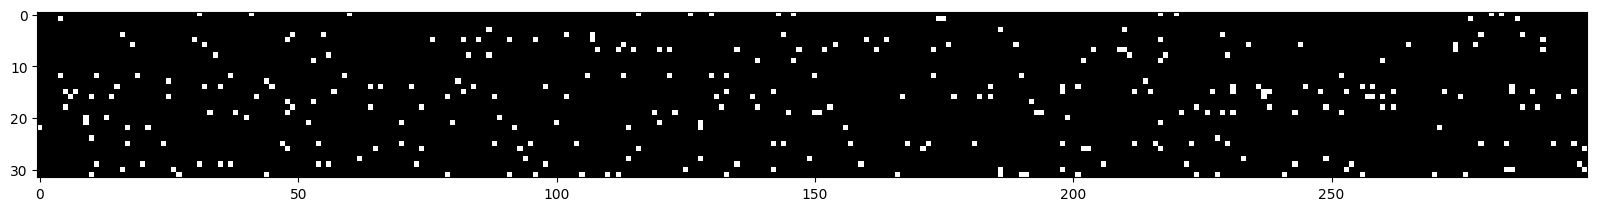

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() >0.99, cmap='gray', interpolation='nearest')

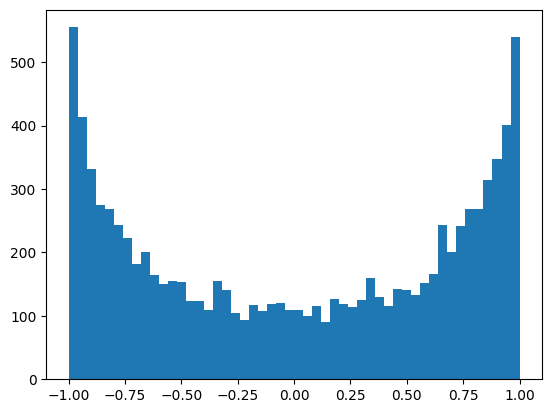

In [12]:
plt.hist(h.view(-1).tolist(), 50);

In [42]:
X_summa = torch.randn((100,10))
X_tanh = torch.tanh(X_summa)

X_tanh.std(), X_tanh.std() * 5/3, X_summa.std(), X_tanh.std()/X_summa.std()

(tensor(0.6290), tensor(1.0483), tensor(1.0113), tensor(0.6220))

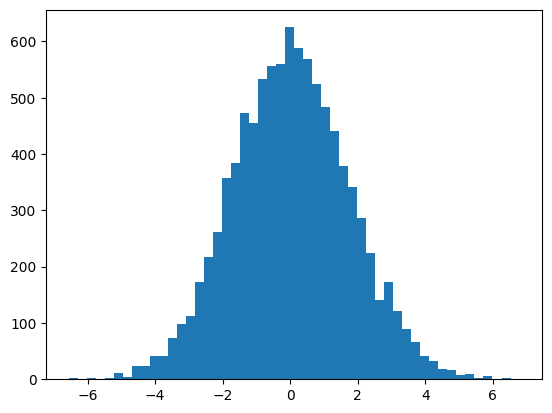

In [43]:
plt.hist((emb @ W1 + b1).view(-1).tolist(), 50);

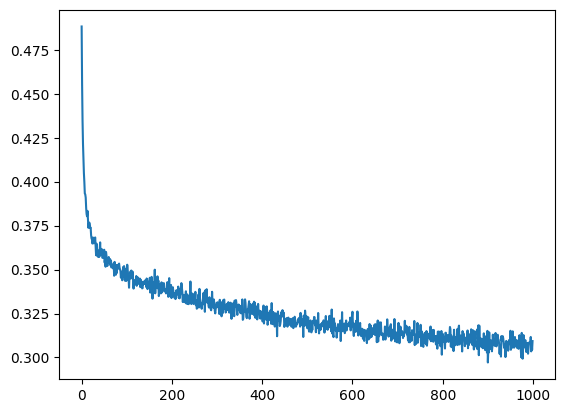

In [19]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(lossi).view(1000, -1).mean(1))

In [21]:
@torch.no_grad() # disable gradient book-keeping
def split_loss(string):
    X, Y = {
    'test': {Xte, Yte},
    'train': {Xtr, Ytr},
    'dev': {Xdev, Ydev}
    }[string]
    emb = C[X]
    emb = emb.view((emb.shape[0], blocksize*n_emb), 1) 
    hpreact = emb @ W1 
    h = torch.tanh(bngain * ((hpreact - bnmean_running/bnstd_running) + bnbias))
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)    
    print(string + ' loss:', loss.item())

split_loss('test')
split_loss('dev')

test loss: 2.159180164337158
dev loss: 2.175894021987915


In [22]:
base_loss.item()

3.295837163925171

In [23]:
for _ in range(20):
    out = []
    context = [0] * blocksize
    while True: 
        emb = C[torch.tensor([context])]
        emb = emb.view(1, -1) 
        hpreact = emb @ W1 
        h = torch.tanh(bngain * ((hpreact - bnmean_running/bnstd_running) + bnbias))
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
    
        ix = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

jacki.
tathany.
kaylynn.
juliahante.
ciana.
aubriann.
donia.
agid.
ravydeh.
hudiza.
jailand.
millianna.
courtniyah.
bocklynn.
alexxthtantirog.
cypranceriokri.
marriyah.
annetthir.
amiyah.
dechrisha.
